In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions


In [2]:
def append_ones(matrix, axis=1):
    return np.concatenate(
        (matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis
    )


def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq, size):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector):
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]

    space_between_tiles = 2
    img_matrix = np.empty(
        shape=(
            rows_count * (tile_height + space_between_tiles) - space_between_tiles,
            cols_count * (tile_width + space_between_tiles) - space_between_tiles,
        )
    )
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + tile_height, y_0 : y_0 + tile_width] = (
                examples[r, c] - ex_min
            ) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Activation functions


In [3]:
def sigmoid(batch):
    return 1.0 / (1.0 + np.exp(-batch))


def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

# MNIST dataset


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/671394299.py:4: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  digits = np.reshape(mnist.train_images()[: 12 * 24], newshape=(12, 24, 28, 28))


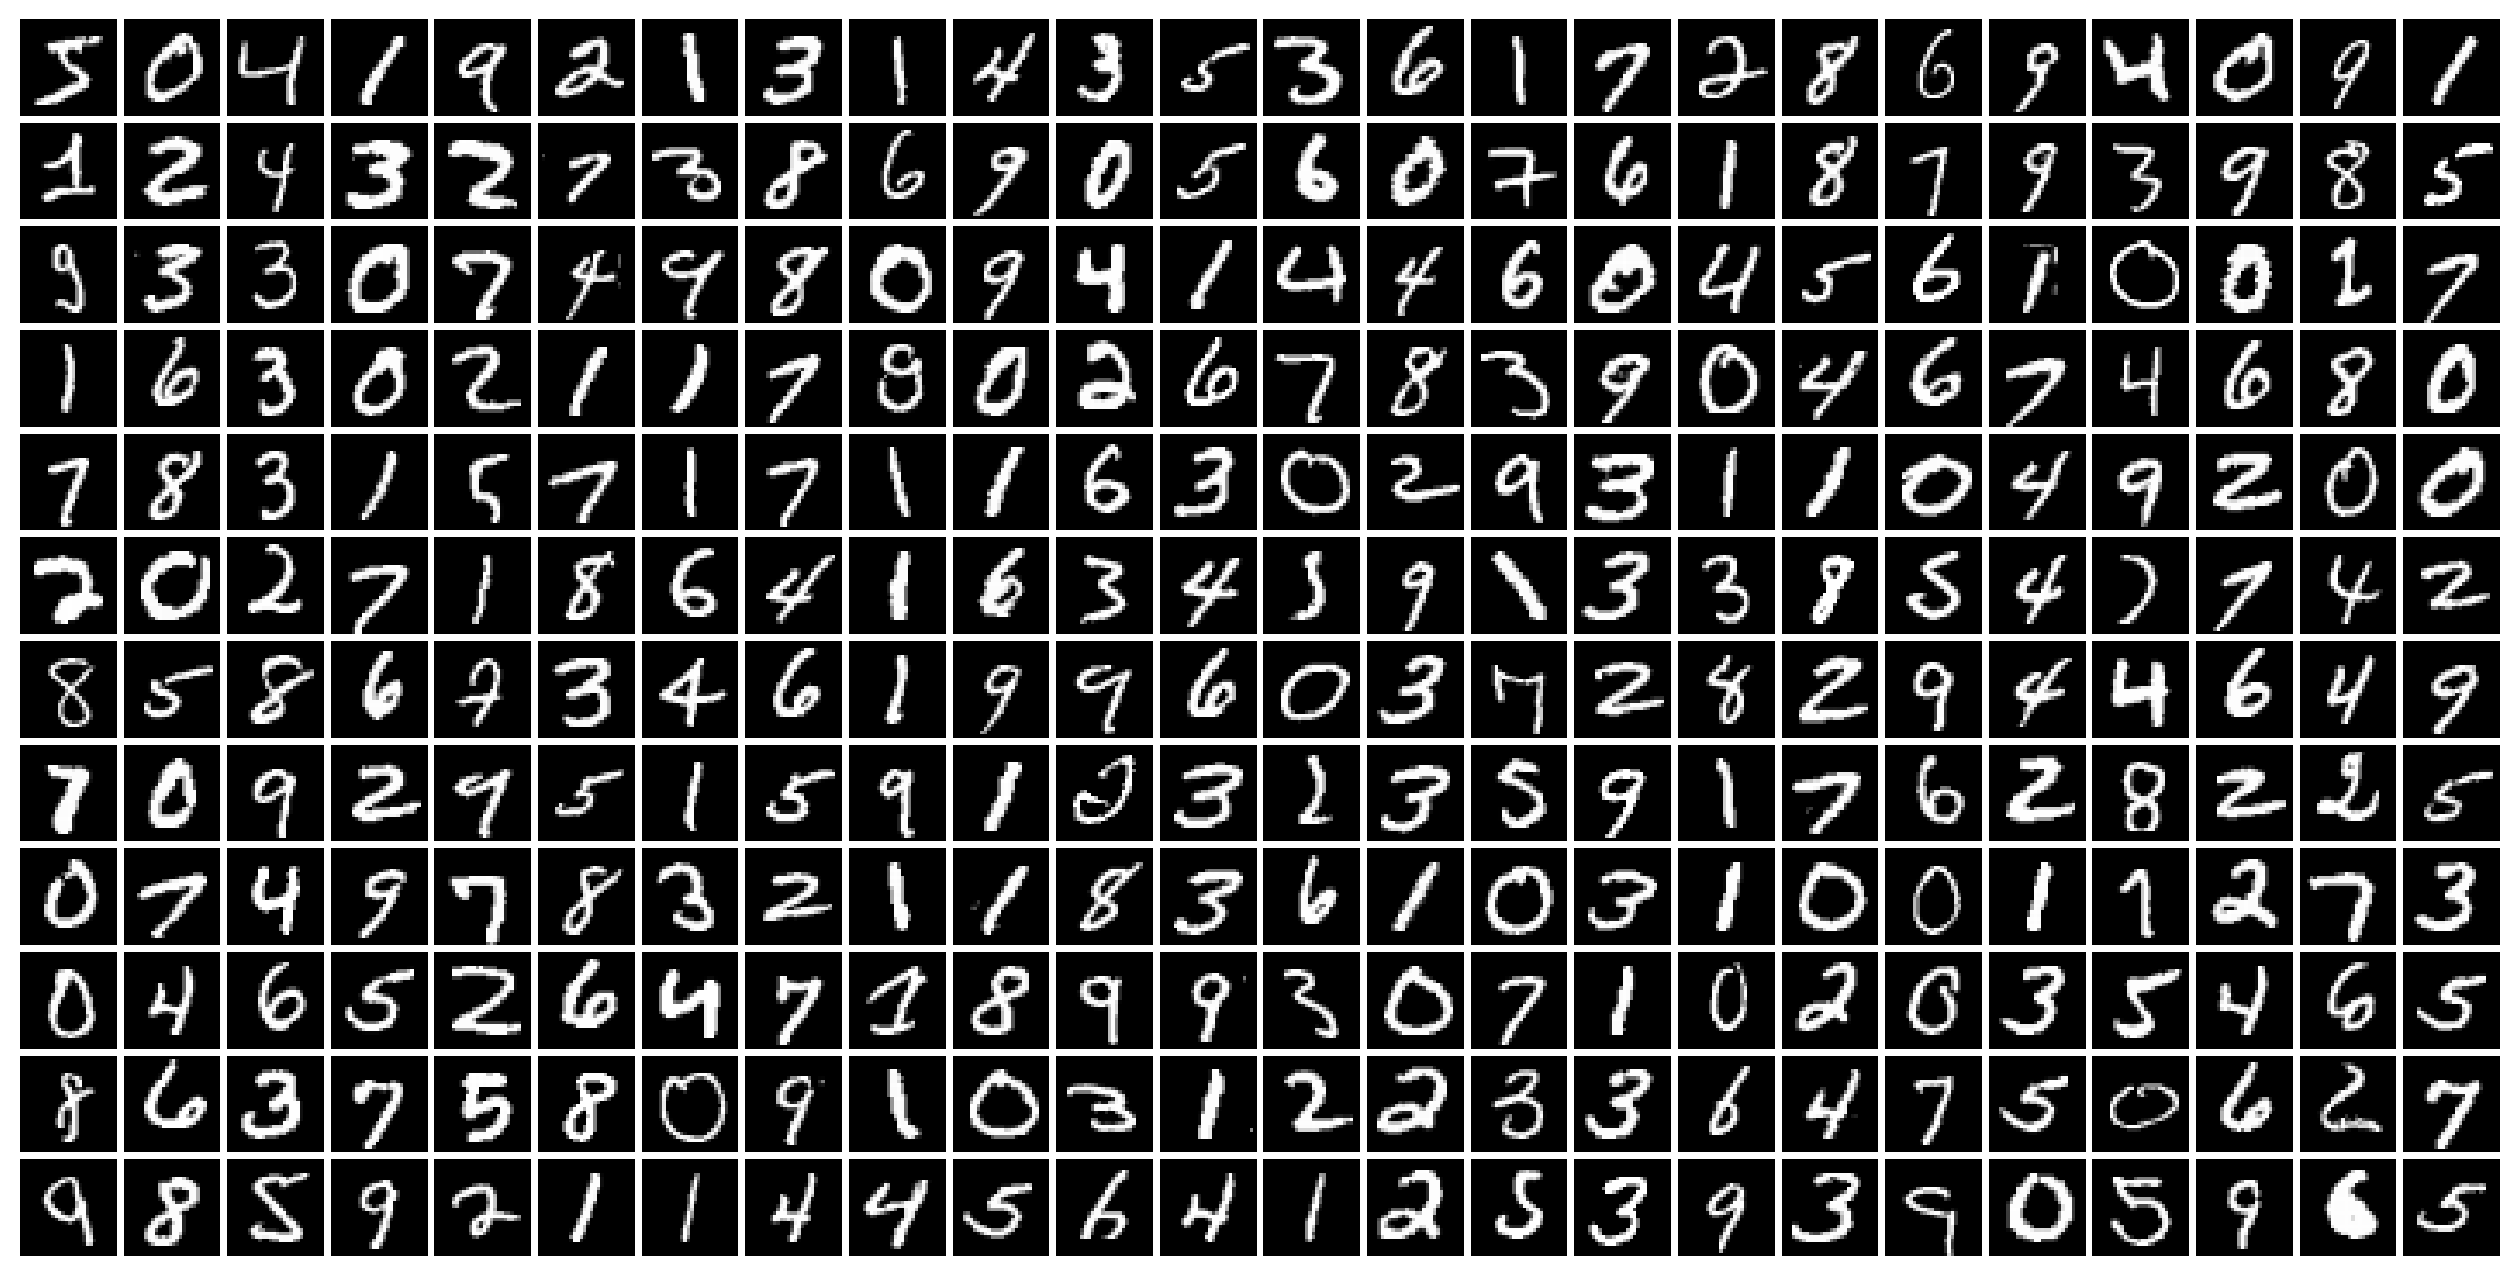

In [4]:
from mnists import MNIST

mnist = MNIST()
digits = np.reshape(mnist.train_images()[: 12 * 24], newshape=(12, 24, 28, 28))
tiles(digits)

# Part 1: $L^1$ and $L^2$ penalties


In [5]:
class Rbm:
    def __init__(
        self, visible_size, hidden_size, learning_rate, momentum, l1_penalty, l2_penalty
    ):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

        self.reset()

    def reset(self):
        self.W = np.random.normal(
            scale=0.01, size=(self.visible_size + 1, self.hidden_size + 1)
        ).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size + 1, self.hidden_size + 1)

In [6]:
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(
        hidden.shape[0], hidden.shape[1] - 1
    )
    visible = sigmoid(hidden @ rbm.W[:-1, :].T)

    error = np.sum((minibatch[:, :-1] - visible) ** 2) / observations_count
    return error

In [7]:
def train_epoch(rbm, dataset, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")


def run_training(rbm, dataset, monitoring_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        if epoch == 5:
            rbm.momentum = 0.8

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size)
        elapsed = time.time() - start_time

        error = reconstuction_error(rbm, monitoring_set)
        print(
            "\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(
                elapsed, error
            )
        )

    print("Training finished!")


def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

### CDK with regulatization

Implement the Contrastive Divergence algorithm with $L^1$ and $L^2$ penalties. If

```python
rbm.l1_penalty > 0
```

the algorithm should constrain the weights with $L^1$ penalty. Otherwise, if

```python
rbm.l2_penalty > 0
```

the algorithm should constrain the weights with $L^2$ penalty.

Do **not** apply the penalties to the biases!


In [8]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    # Inicjalizacja warstw aktywacji
    # - positive_visible: Original input data (with bias term)
    # - negative_visible: Will store reconstructed visible layer (initialized to zeros + bias)
    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    # Initialize hidden layer matrices:
    # - positive_hidden: Hidden activations for positive phase (initialized to zeros + bias)
    # - negative_hidden: Hidden activations for negative phase (initialized to zeros + bias)
    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    # Pozytywna faza: propagacja do warstwy ukrytej
    # ===== POSITIVE PHASE =====
    # Compute hidden layer probabilities given visible data (forward pass)
    # - rbm.W[:, :-1] excludes the bias weights for hidden units
    # - sigmoid converts logits to probabilities
    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])

    # Compute positive gradient (data-dependent statistics)
    # - This is E[vh^T] under the data distribution
    # - Divided by batch size to get average gradient
    pos_grad = (positive_visible.T @ positive_hidden) / observations_count

    # Negatywna faza: próbkujemy przez Gibbs sampling
    # ===== NEGATIVE PHASE (Gibbs Sampling) =====
    # Initial Gibbs sampling step:
    # 1. Sample hidden units given visible data (using probabilities from positive phase)
    #    - positive_hidden[:, :-1] are probabilities (from sigmoid)
    #    - rand() generates uniform random numbers for thresholding
    #    - '>' performs Bernoulli sampling

    negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(
        positive_hidden.shape[0], positive_hidden.shape[1] - 1
    )

    # 2. Sample visible units given hidden samples
    #    - rbm.W[:-1, :].T is the transpose of weights (excluding visible bias)
    negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(
        *negative_visible[:, :-1].shape
    )

    # Additional Gibbs steps (if k > 1)
    for _ in range(k - 1):
        # Sample hidden units again given reconstructed visible units
        negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1]) > rand(
            *negative_hidden[:, :-1].shape
        )
        # Sample visible units again given new hidden units
        negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(
            *negative_visible[:, :-1].shape
        )

    # Ostateczna aktualizacja dla negatywnej fazy (bez samplowania) do policzenia gradientu
    negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1])
    # Compute negative gradient
    # - This is E[vh^T] under the model's distribution
    neg_grad = (negative_visible.T @ negative_hidden) / observations_count

    # Aktualizacja wag RBM
    # ===== WEIGHT UPDATE =====
    # Update rule: ΔW = η*(positive_gradient - negative_gradient)
    # - Learning rate (η) scales the update
    # - pos_grad pushes weights toward data distribution
    # - neg_grad pulls weights away from model distribution
    learning_rate = rbm.learning_rate
    momentum = rbm.momentum

    # Regularization
    gradient = pos_grad - neg_grad

    if rbm.l1_penalty > 0:
        gradient[:-1, :-1] -= np.sign(rbm.W[:-1, :-1]) * rbm.l1_penalty
    elif rbm.l2_penalty > 0:
        gradient[:-1, :-1] -= rbm.W[:-1, :-1] * rbm.l2_penalty

    rbm.M = momentum * rbm.M + learning_rate * gradient
    rbm.W += rbm.M

## Comparison of regularization penalties


In [9]:
DATASET_SIZE = 20000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(
    mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
)
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/240741261.py:9: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  dataset = np.reshape(


In [10]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

### RBM with no regularization


In [11]:
L1_PENALTY = 0.0
L2_PENALTY = 0.0

np.random.seed(1234)
rbm_plain = Rbm(
    VISIBLE_LAYER_SIZE,
    HIDDEN_LAYER_SIZE,
    LEARNING_RATE,
    MOMENTUM,
    L1_PENALTY,
    L2_PENALTY,
)

run_training(rbm_plain, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: divide by zero encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: overflow encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: invalid value encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: divide by zero encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden) / observations_count
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: overflow encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden

Epoch 1:	########################################	elapsed: 0.15s, reconstruction error: 26.21
Epoch 2:	########################################	elapsed: 0.14s, reconstruction error: 21.08
Epoch 3:	########################################	elapsed: 0.13s, reconstruction error: 18.67
Epoch 4:	########################################	elapsed: 0.14s, reconstruction error: 17.35
Epoch 5:	########################################	elapsed: 0.14s, reconstruction error: 16.32
Epoch 6:	########################################	elapsed: 0.14s, reconstruction error: 14.94
Epoch 7:	########################################	elapsed: 0.13s, reconstruction error: 14.02
Epoch 8:	########################################	elapsed: 0.14s, reconstruction error: 13.44
Epoch 9:	########################################	elapsed: 0.14s, reconstruction error: 12.78
Epoch 10:	########################################	elapsed: 0.14s, reconstruction error: 12.51
Epoch 11:	########################################	elapsed:

### RBM with $L^1$ penalty


In [12]:
L1_PENALTY = 0.0001
L2_PENALTY = 0.0

np.random.seed(1234)
rbm_l1 = Rbm(
    VISIBLE_LAYER_SIZE,
    HIDDEN_LAYER_SIZE,
    LEARNING_RATE,
    MOMENTUM,
    L1_PENALTY,
    L2_PENALTY,
)

run_training(rbm_l1, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 0.17s, reconstruction error: 26.36
Epoch 2:	########

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: divide by zero encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: overflow encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: invalid value encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: divide by zero encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden) / observations_count
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: overflow encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden

################################	elapsed: 0.19s, reconstruction error: 21.14
Epoch 3:	########################################	elapsed: 0.17s, reconstruction error: 18.73
Epoch 4:	########################################	elapsed: 0.18s, reconstruction error: 17.31
Epoch 5:	########################################	elapsed: 0.19s, reconstruction error: 16.24
Epoch 6:	########################################	elapsed: 0.18s, reconstruction error: 14.93
Epoch 7:	########################################	elapsed: 0.17s, reconstruction error: 13.98
Epoch 8:	########################################	elapsed: 0.18s, reconstruction error: 13.36
Epoch 9:	########################################	elapsed: 0.18s, reconstruction error: 12.62
Epoch 10:	########################################	elapsed: 0.18s, reconstruction error: 12.24
Epoch 11:	########################################	elapsed: 0.19s, reconstruction error: 12.07
Epoch 12:	########################################	elapsed: 0.18s, reconstr

### RBM with $L^2$ penalty


In [13]:
L1_PENALTY = 0.0
L2_PENALTY = 0.0005

np.random.seed(1234)
rbm_l2 = Rbm(
    VISIBLE_LAYER_SIZE,
    HIDDEN_LAYER_SIZE,
    LEARNING_RATE,
    MOMENTUM,
    L1_PENALTY,
    L2_PENALTY,
)

run_training(rbm_l2, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 0.14s, reconstruction error: 26.24
Epoch 2:	################

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: divide by zero encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: overflow encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: invalid value encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: divide by zero encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden) / observations_count
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: overflow encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden

########################	elapsed: 0.15s, reconstruction error: 21.17
Epoch 3:	########################################	elapsed: 0.15s, reconstruction error: 18.73
Epoch 4:	########################################	elapsed: 0.14s, reconstruction error: 17.31
Epoch 5:	########################################	elapsed: 0.15s, reconstruction error: 16.39
Epoch 6:	########################################	elapsed: 0.18s, reconstruction error: 15.08
Epoch 7:	########################################	elapsed: 0.15s, reconstruction error: 14.05
Epoch 8:	########################################	elapsed: 0.15s, reconstruction error: 13.42
Epoch 9:	########################################	elapsed: 0.16s, reconstruction error: 12.88
Epoch 10:	########################################	elapsed: 0.16s, reconstruction error: 12.51
Epoch 11:	########################################	elapsed: 0.15s, reconstruction error: 12.09
Epoch 12:	########################################	elapsed: 0.16s, reconstruction e

### Plain filters


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/736168039.py:31: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))


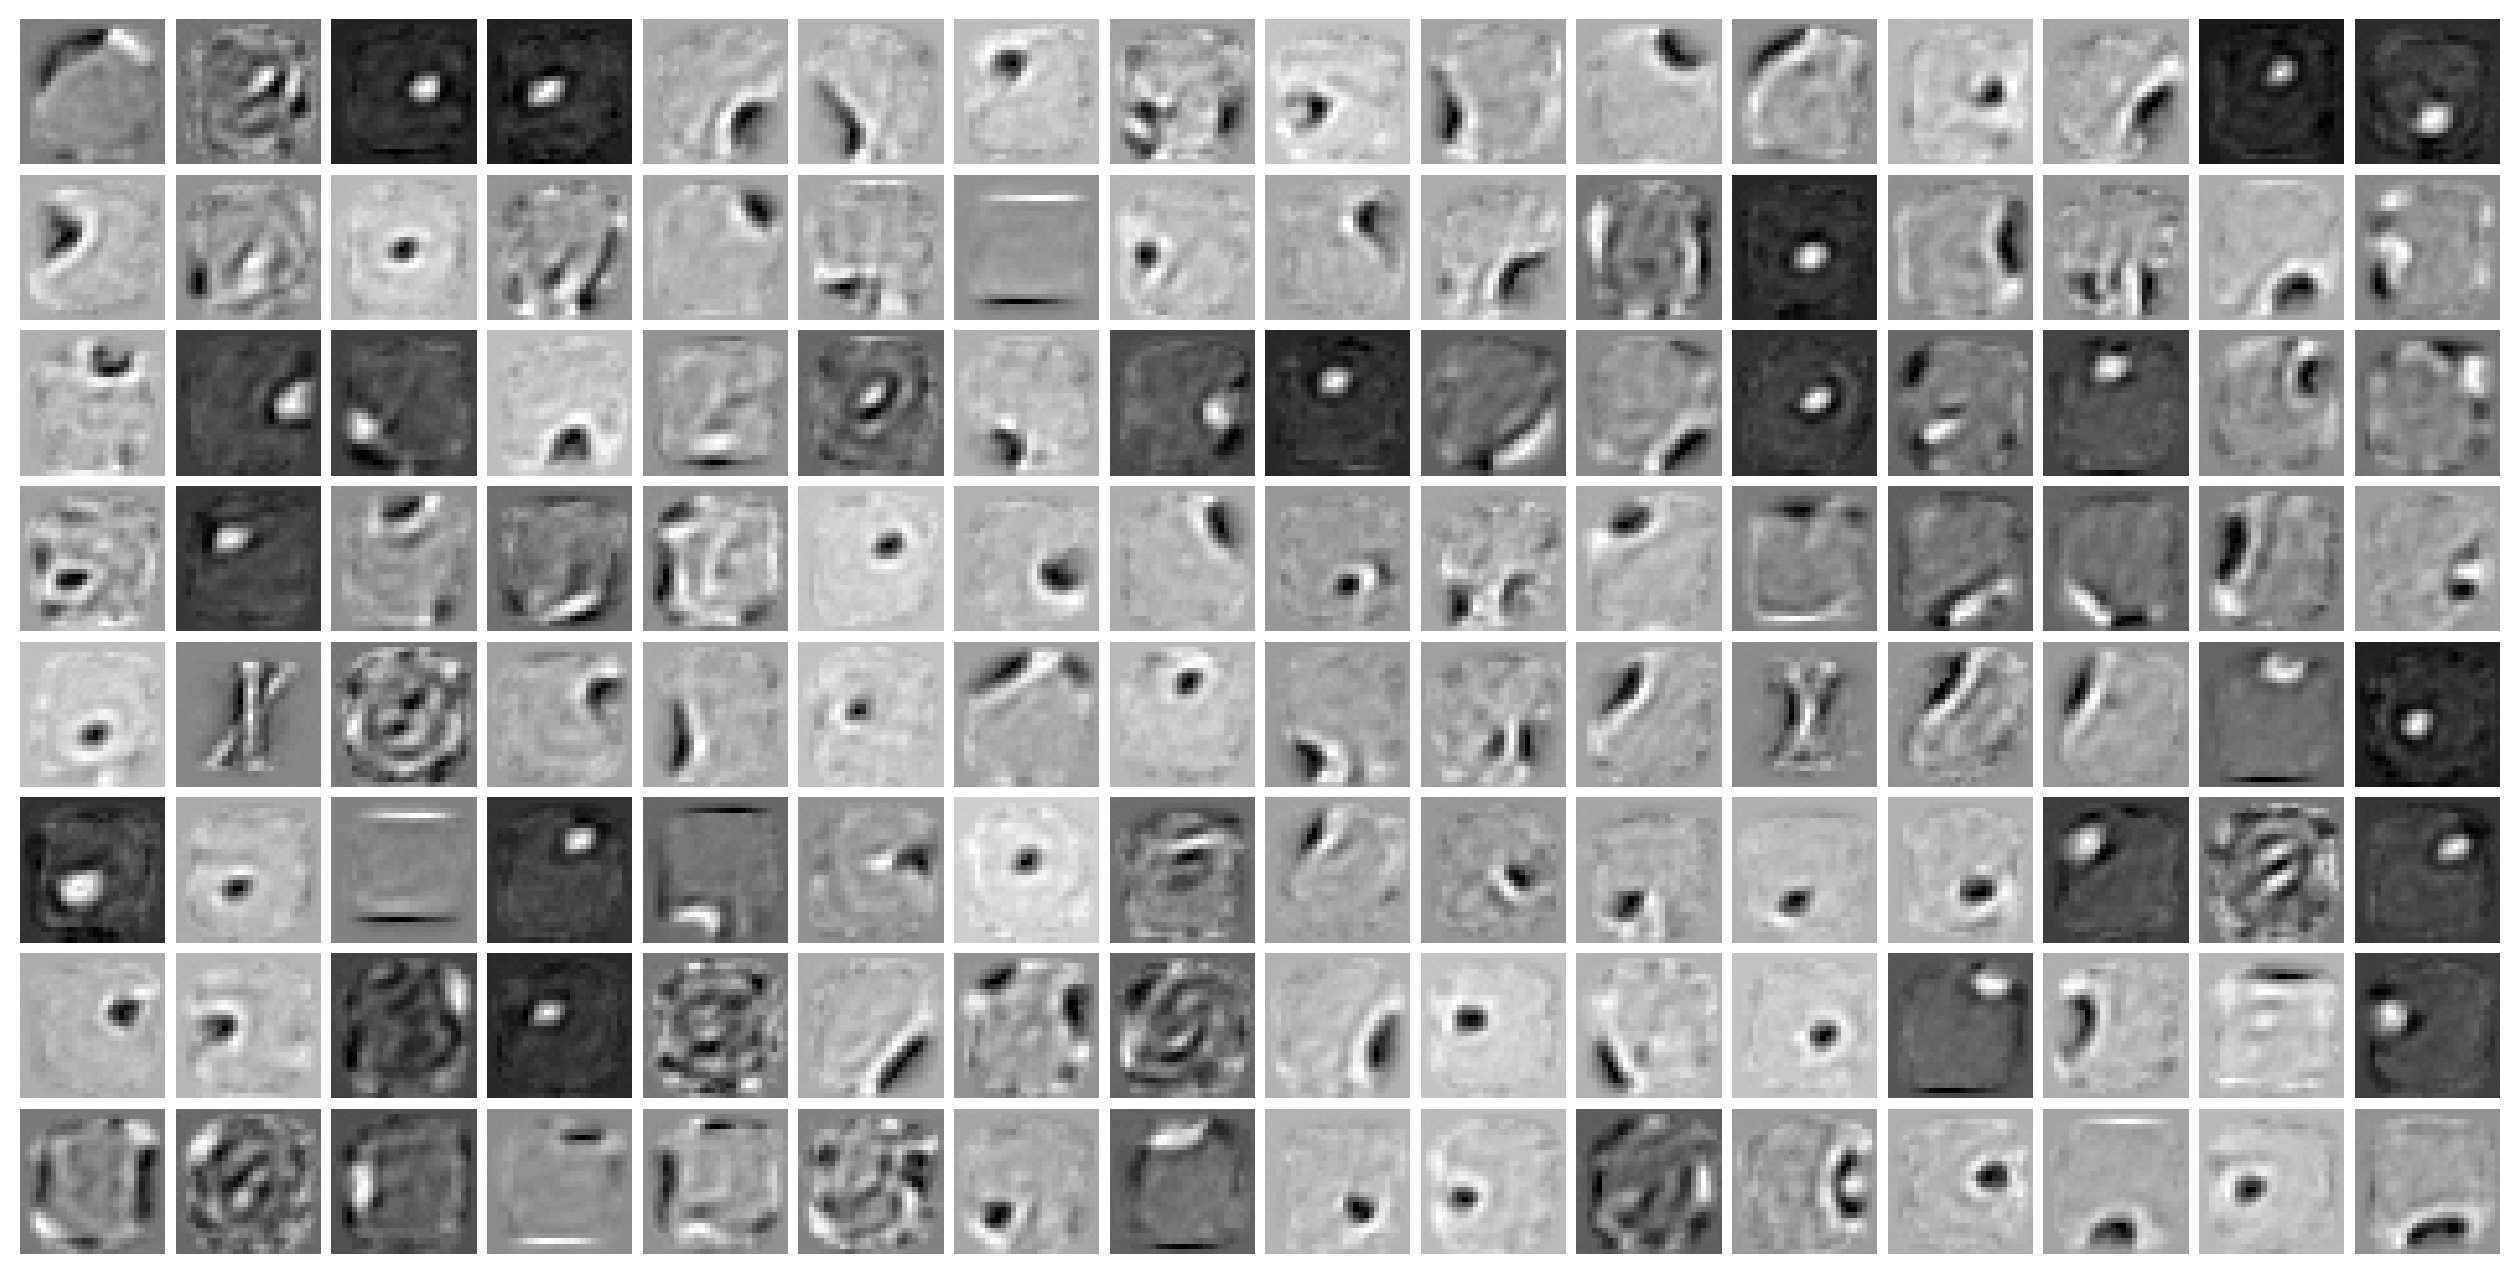

In [14]:
draw_filters(rbm_plain)

### $L^1$ filters


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/736168039.py:31: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))


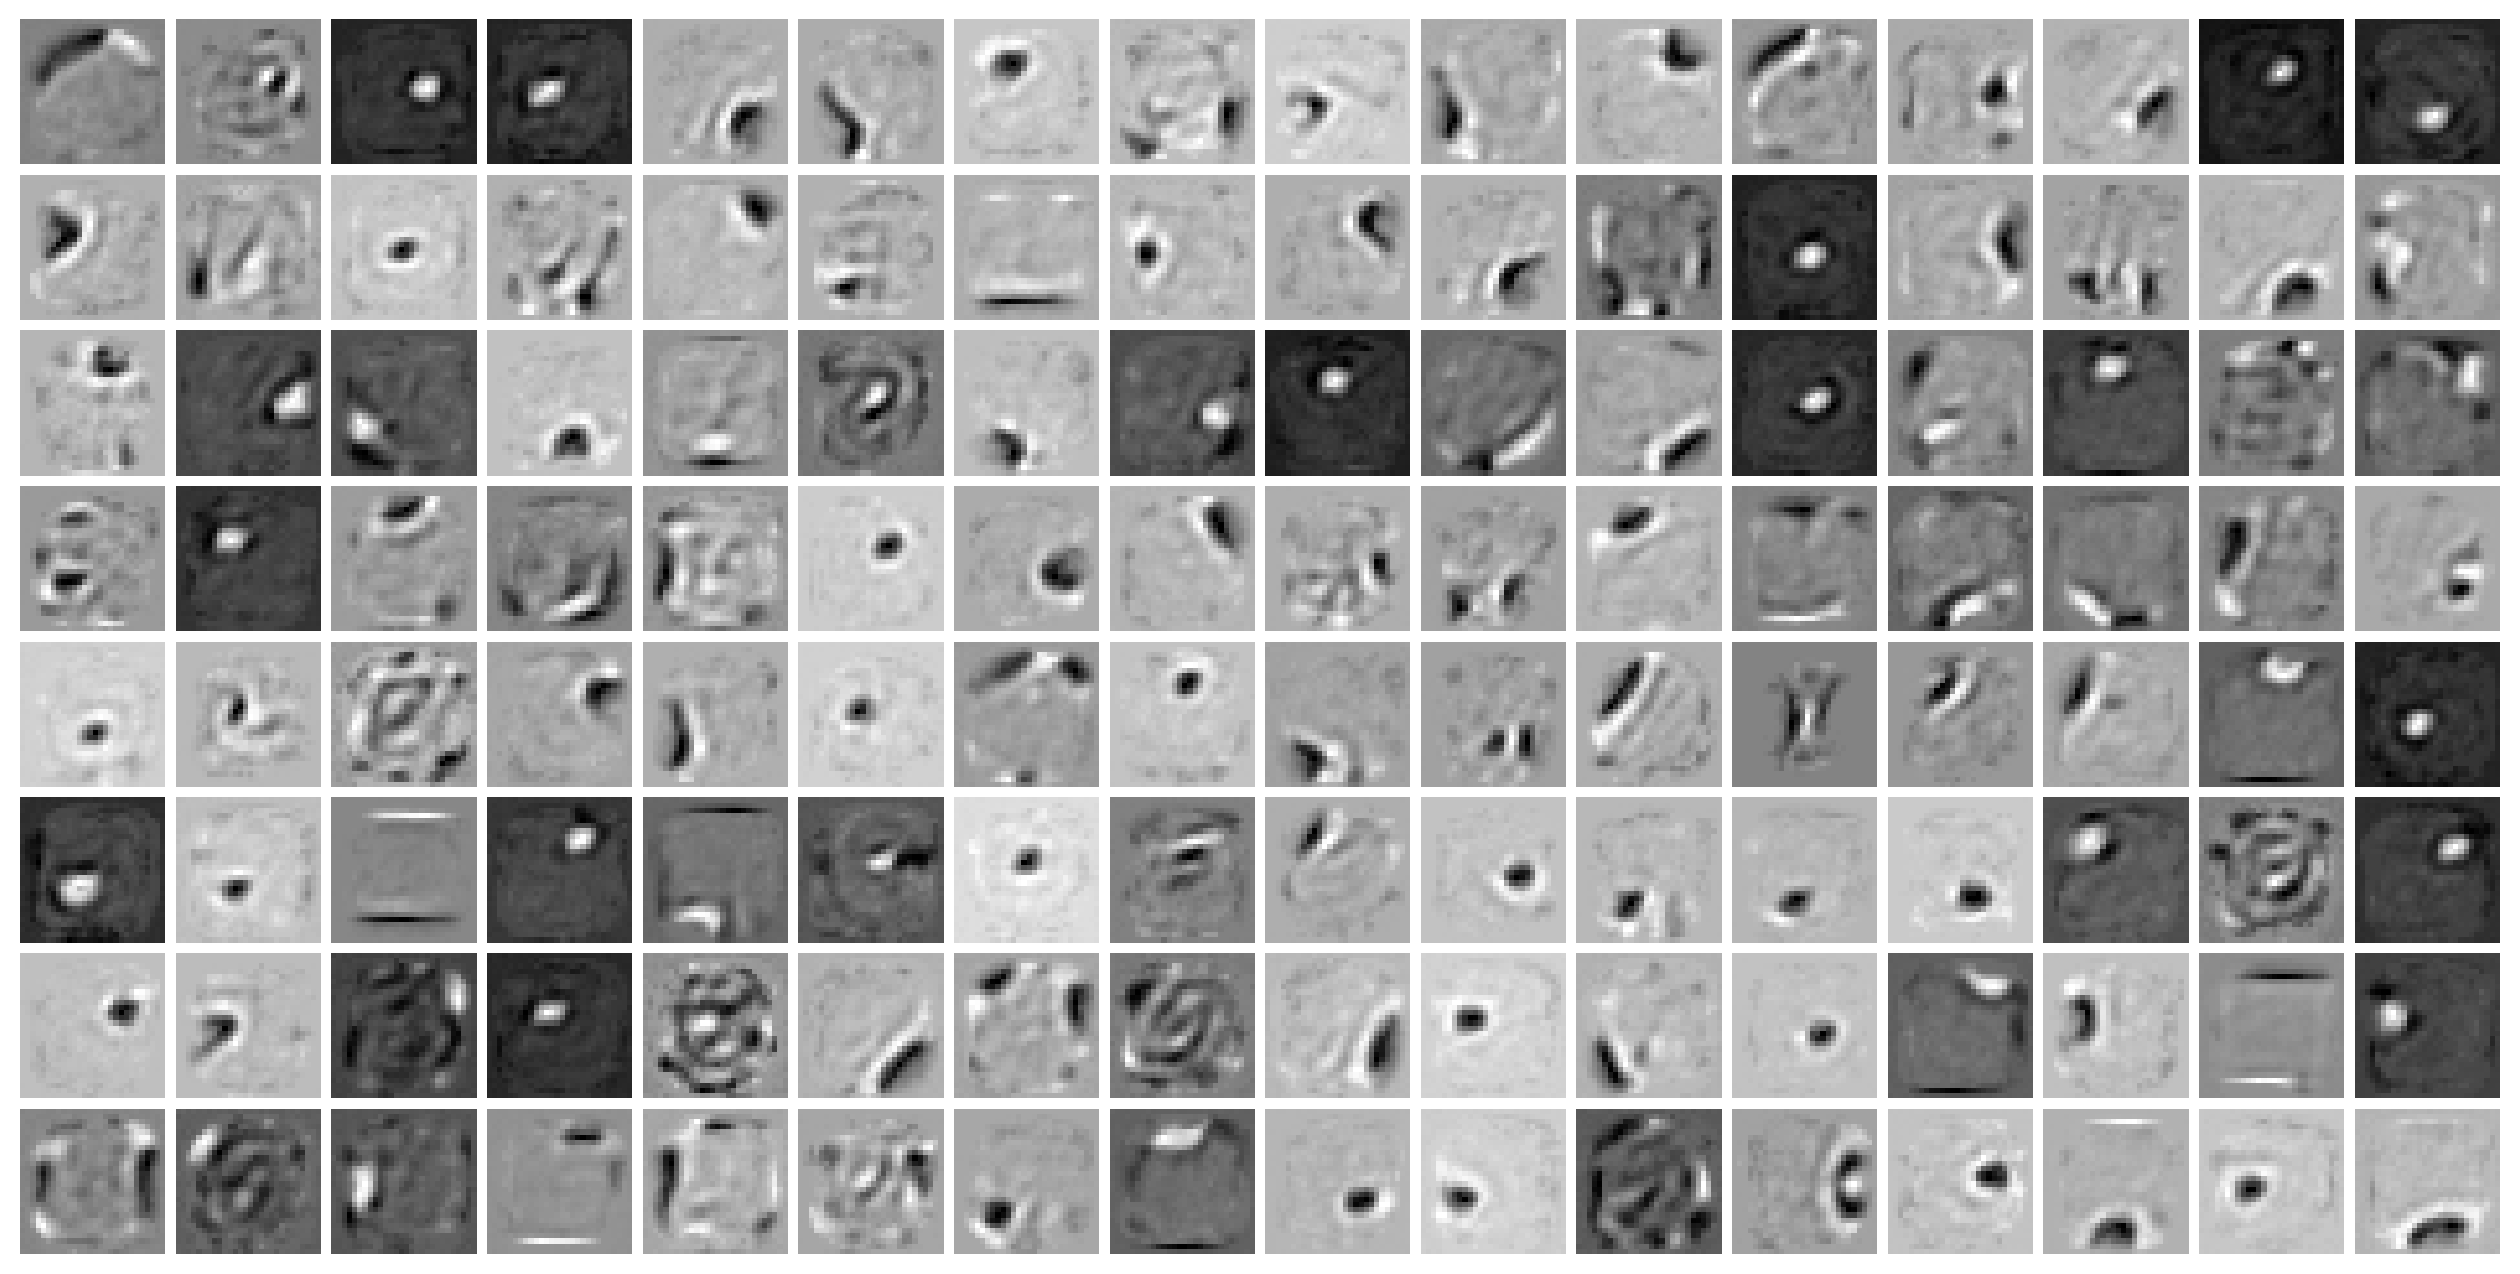

In [15]:
draw_filters(rbm_l1)

### $L^2$ filters


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/736168039.py:31: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))


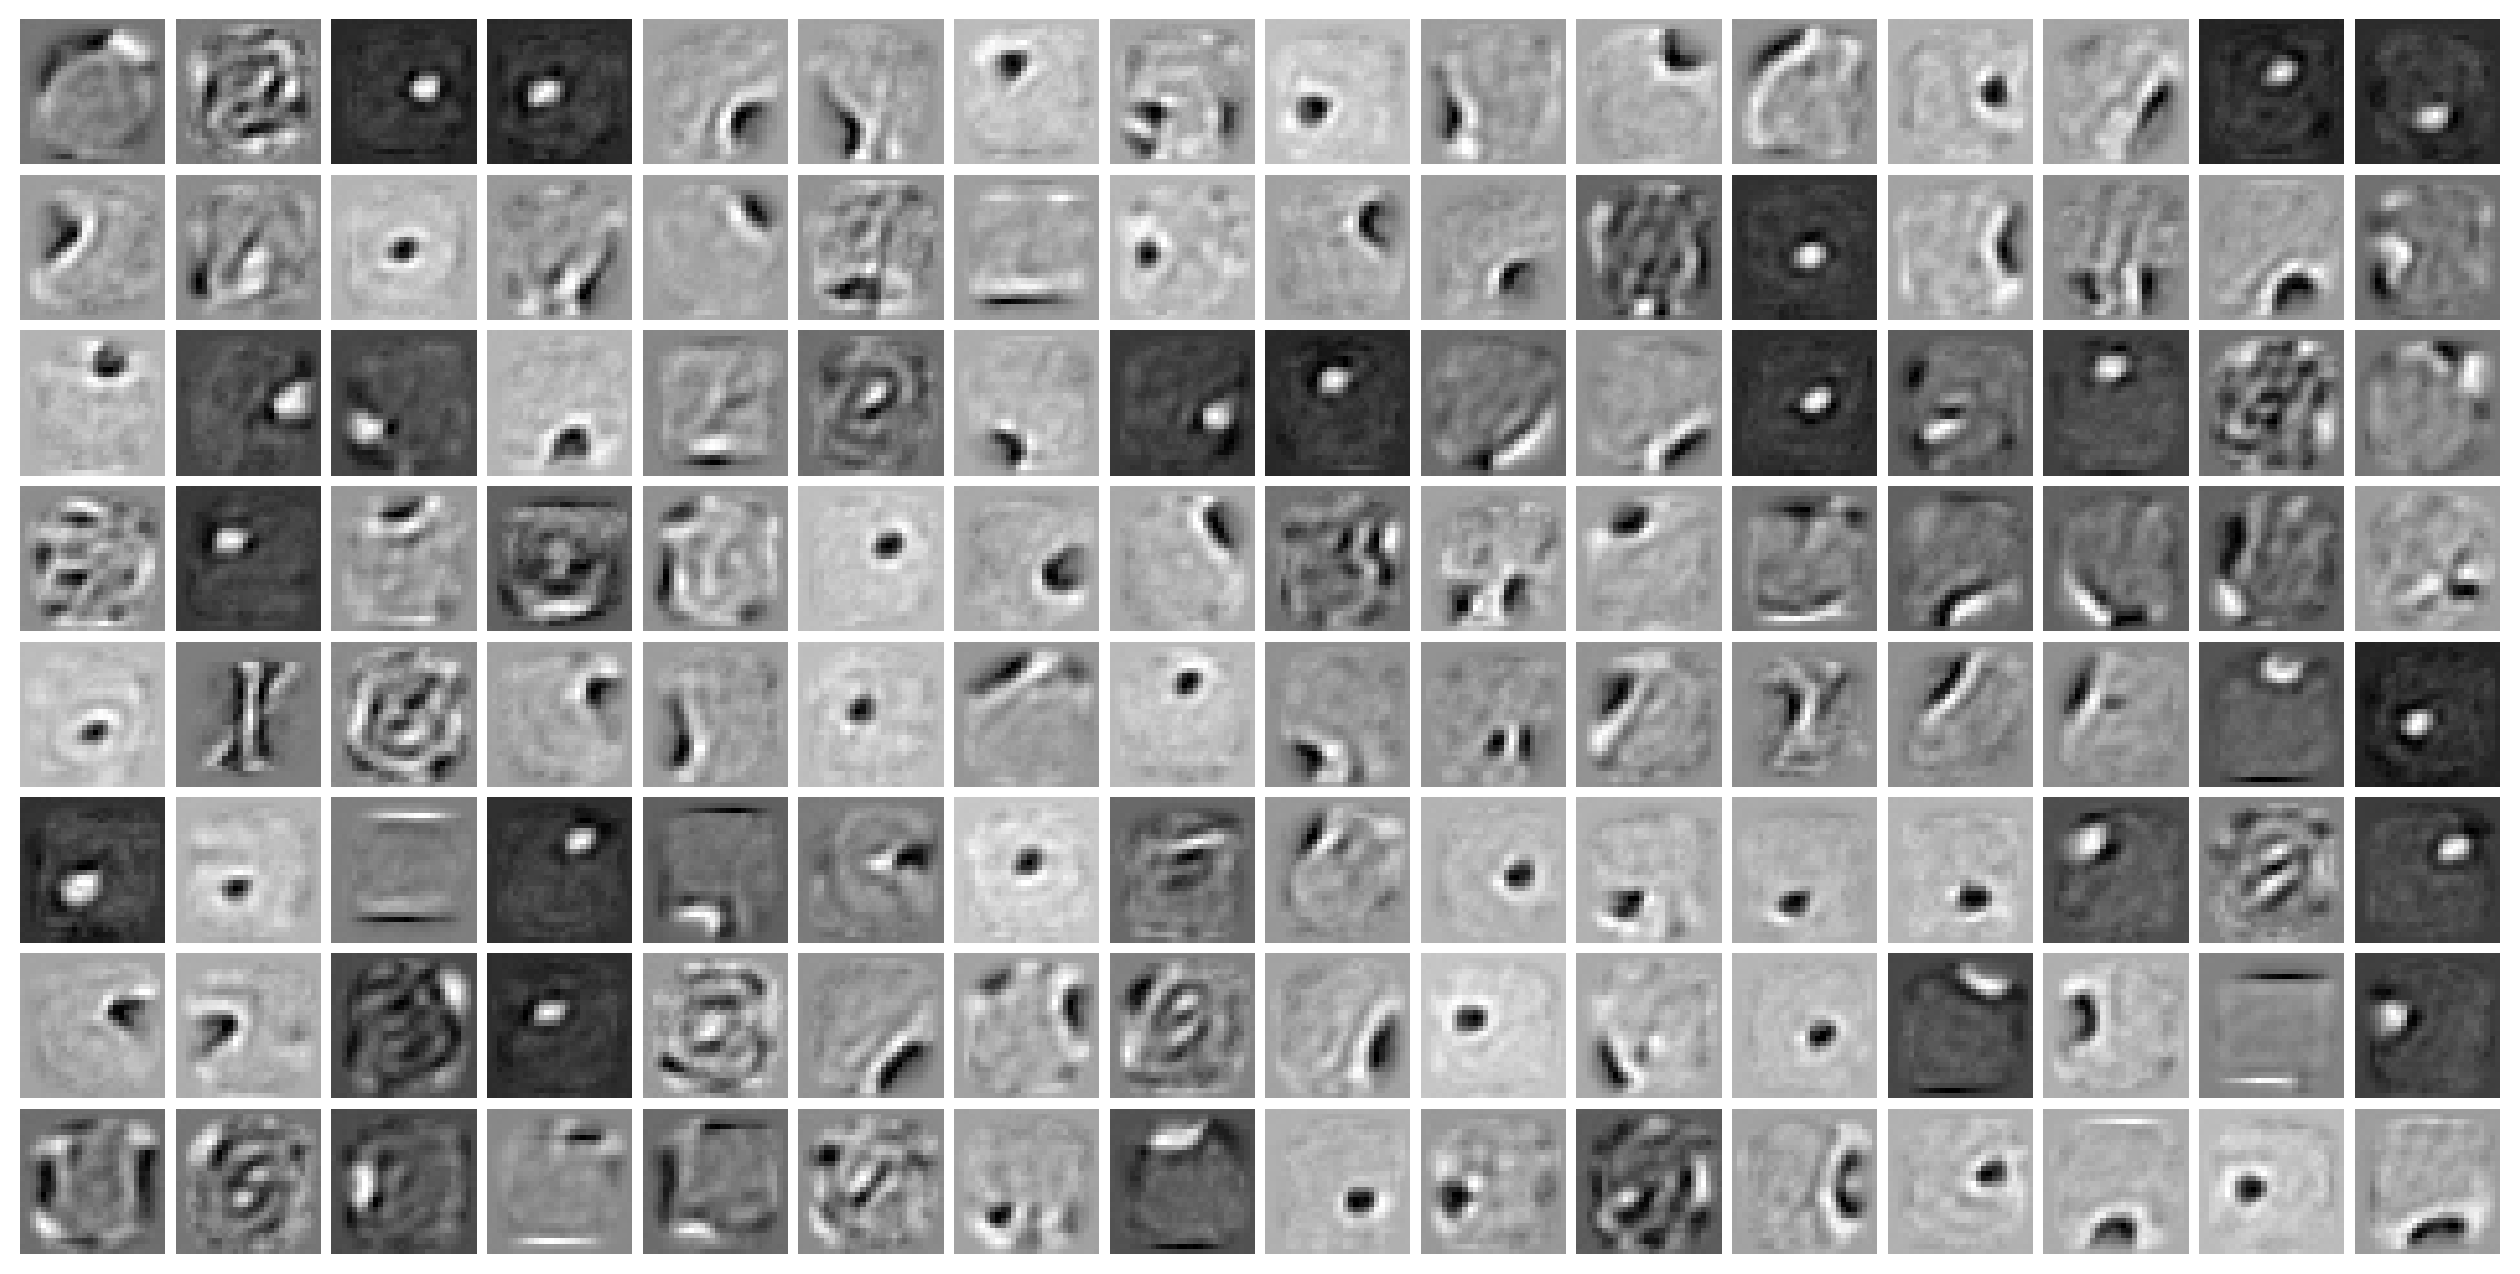

In [16]:
draw_filters(rbm_l2)

# Part 2: MLP pretraining


In [17]:
def softmax(batch):
    z = batch - np.max(batch, axis=1, keepdims=True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=1, keepdims=True)

    return numerator / denominator

In [18]:
class Layer:
    def __init__(
        self,
        visible_size,
        hidden_size,
        activation_fun,
        d_activation_fun,
        learning_rate,
        momentum,
        l2_penalty,
    ):
        self.visible_size = visible_size
        self.hidden_size = hidden_size

        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun

        self.learning_rate = learning_rate
        self.momentum = momentum

        self.l2_penalty = l2_penalty

        self.reset()

    def reset(self):
        self.W = np.random.normal(
            scale=0.01, size=(self.visible_size + 1, self.hidden_size)
        ).astype(np.float32)
        self.W[-1, :] = 0.0

        self.activations = None
        self.d_activations = None
        self.deltas = None

        self.M = zeros(self.visible_size + 1, self.hidden_size)

### Forward pass


In [19]:
def forward_pass(mlp, batch, compute_derivatives):
    visible = batch

    for layer_idx, layer in enumerate(mlp):
        z = visible @ layer.W
        layer.activations = append_ones(layer.activation_fun(z))

        if compute_derivatives and (layer_idx < len(mlp) - 1):
            layer.d_activations = layer.d_activation_fun(z)

        visible = layer.activations

    return visible[:, :-1]

### Error backpropagation

Extend the implementation of error backpropagation (from Lab 6) with $L^2$ penalty. Apply the penalty when:

```python
rbm.l2_penalty > 0
```

Do **not** apply the penalty to the biases.


In [20]:
def error_backpropagate(mlp, batch):
    observations_count = batch.shape[0]

    for layer_idx, layer in reversed(list(enumerate(mlp))):
        if layer_idx > 0:
            prev_layer = mlp[layer_idx - 1]
            visible = prev_layer.activations

            prev_layer.deltas = (
                layer.deltas @ layer.W[:-1].T
            ) * prev_layer.d_activations
        else:
            visible = batch

        gradient = (visible.T @ layer.deltas) / observations_count

        # Regularization
        if layer.l2_penalty > 0:
            gradient[:-1, :] += layer.l2_penalty * layer.W[:-1, :]

        layer.M = layer.momentum * layer.M - layer.learning_rate * gradient
        layer.W += layer.M

### MLP training


In [21]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] / batch_size

    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)

    for batch_idx, (batch, batch_labels) in enumerate(
        zip(batched_data, batched_labels)
    ):
        # Forward pass: compute activatations and derivatives of activations
        y = forward_pass(mlp, batch, True)

        mlp[-1].deltas = y - batch_labels

        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, batch)

        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [22]:
def classify(mlp, batch):
    probabilities = forward_pass(mlp, batch, False)
    return np.argmax(probabilities, axis=1)


def run_mlp_training(
    mlp,
    train_set,
    train_labels,
    validation_set,
    validation_labels,
    batch_size,
    epochs_count,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        if epoch == 5:
            for layer in mlp:
                layer.momentum = 0.9

        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, validation_set)
        accuracy = (
            100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        )
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")


def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))
    tiles(filters)

## DBN Pretraining


In [23]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
    return visible


def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(sigmoid(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

In [24]:
def dbn_reconstuction_error(dbn, layers_count, minibatch):
    propagated = propagate_up(dbn, layers_count, minibatch)
    return reconstuction_error(dbn[layers_count], propagated)

In [25]:
def train_dbn_layer(dbn, layer_idx, dataset, batch_size):
    dataset = propagate_up(dbn, layer_idx, dataset)

    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [26]:
def train_dbn(dbn, dataset, monitoring_set, batch_size, epochs_count):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))

        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch + 1), end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print(
                "\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(
                    elapsed, error
                )
            )

## Initializing MLP with DBN weights

Implement initialization of MLP weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the MLP weights (and biases) are **copies** of the DBN weights (and biases). You can use `np.copy(...)` function to copy the weights (simple assignment will make a view instead of a copy).


In [27]:
def initialize_mlp(mlp, dbn):
    for layer_idx in range(len(dbn)):
        mlp[layer_idx].W = np.copy(dbn[layer_idx].W[:, :-1])

# MNIST digits classification


In [28]:
np.random.seed(1234)

DATASET_SIZE = 10000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(
    mnist_train_images[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
)
mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(
    mnist_train_images.shape[0], 512, replace=False
)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(
    mnist_test_images, newshape=(-1, DIGIT_SIZE * DIGIT_SIZE)
)
mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/831170026.py:15: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  mnist_train_images = np.reshape(
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/831170026.py:31: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  mnist_test_images = np.reshape(


### Plain vs pretrained MLP comparison


In [29]:
from IPython.core.display import HTML


def compare_pretraining_results(
    mlp,
    dbn,
    train_set,
    train_labels,
    validation_set,
    validation_labels,
    monitoring_set,
    batch_size,
    epochs_count,
):
    for layer in mlp:
        layer.reset()

    display(HTML("<h3>Plain MLP training</h3>"))
    run_mlp_training(
        mlp,
        train_set,
        train_labels,
        validation_set,
        validation_labels,
        batch_size,
        epochs_count,
    )

    display(HTML("<h3>Input layer filters in the plain MLP</h3>"))
    draw_layer_filters(mlp[0])

    display(HTML("<h3>DBN training</h3>"))
    train_dbn(dbn, train_set, monitoring_set, batch_size, epochs_count)

    for layer in mlp:
        layer.reset()

    initialize_mlp(mlp, dbn)

    display(HTML("<h3>Finetuning pretrained MLP</h3>"))
    run_mlp_training(
        mlp,
        train_set,
        train_labels,
        validation_set,
        validation_labels,
        batch_size,
        epochs_count,
    )

    display(HTML("<h3>First layer filters in the DBN</h3>"))
    draw_filters(dbn[0])

    display(HTML("<h3>Input layer filters in the pretrained & finetuned MLP</h3>"))
    draw_layer_filters(mlp[0])

In [30]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.5
L2_PENALTY = 0.00002

### Shallow neural network


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2756254865.py:5: RuntimeWarning: divide by zero encountered in matmul
  z = visible @ layer.W
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2756254865.py:5: RuntimeWarning: overflow encountered in matmul
  z = visible @ layer.W
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2756254865.py:5: RuntimeWarning: invalid value encountered in matmul
  z = visible @ layer.W
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2385301240.py:10: RuntimeWarning: divide by zero encountered in matmul
  layer.deltas @ layer.W[:-1].T
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2385301240.py:10: RuntimeWarning: overflow encountered in matmul
  layer.deltas @ layer.W[:-1].T
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2385301240.py:10: RuntimeWarning: invalid value encountered in matmul
  layer.deltas @ layer.W[:-1].T
/var/folders/8j/_nnvcqj93gvgk18wy

Epoch 1:	########################################	elapsed: 0.06s, accuracy: 10.10
Epoch 2:	########################################	elapsed: 0.06s, accuracy: 10.10
Epoch 3:	########################################	elapsed: 0.06s, accuracy: 8.92
Epoch 4:	########################################	elapsed: 0.06s, accuracy: 8.92
Epoch 5:	########################################	elapsed: 0.06s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 0.07s, accuracy: 15.02
Epoch 7:	########################################	elapsed: 0.06s, accuracy: 27.16
Epoch 8:	########################################	elapsed: 0.06s, accuracy: 31.93
Epoch 9:	########################################	elapsed: 0.06s, accuracy: 33.31
Epoch 10:	########################################	elapsed: 0.06s, accuracy: 46.92
Epoch 11:	########################################	elapsed: 0.06s, accuracy: 52.85
Epoch 12:	########################################	elapsed: 0.06s, accuracy: 58.69
Epoch 13:	#####

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/174255805.py:36: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))


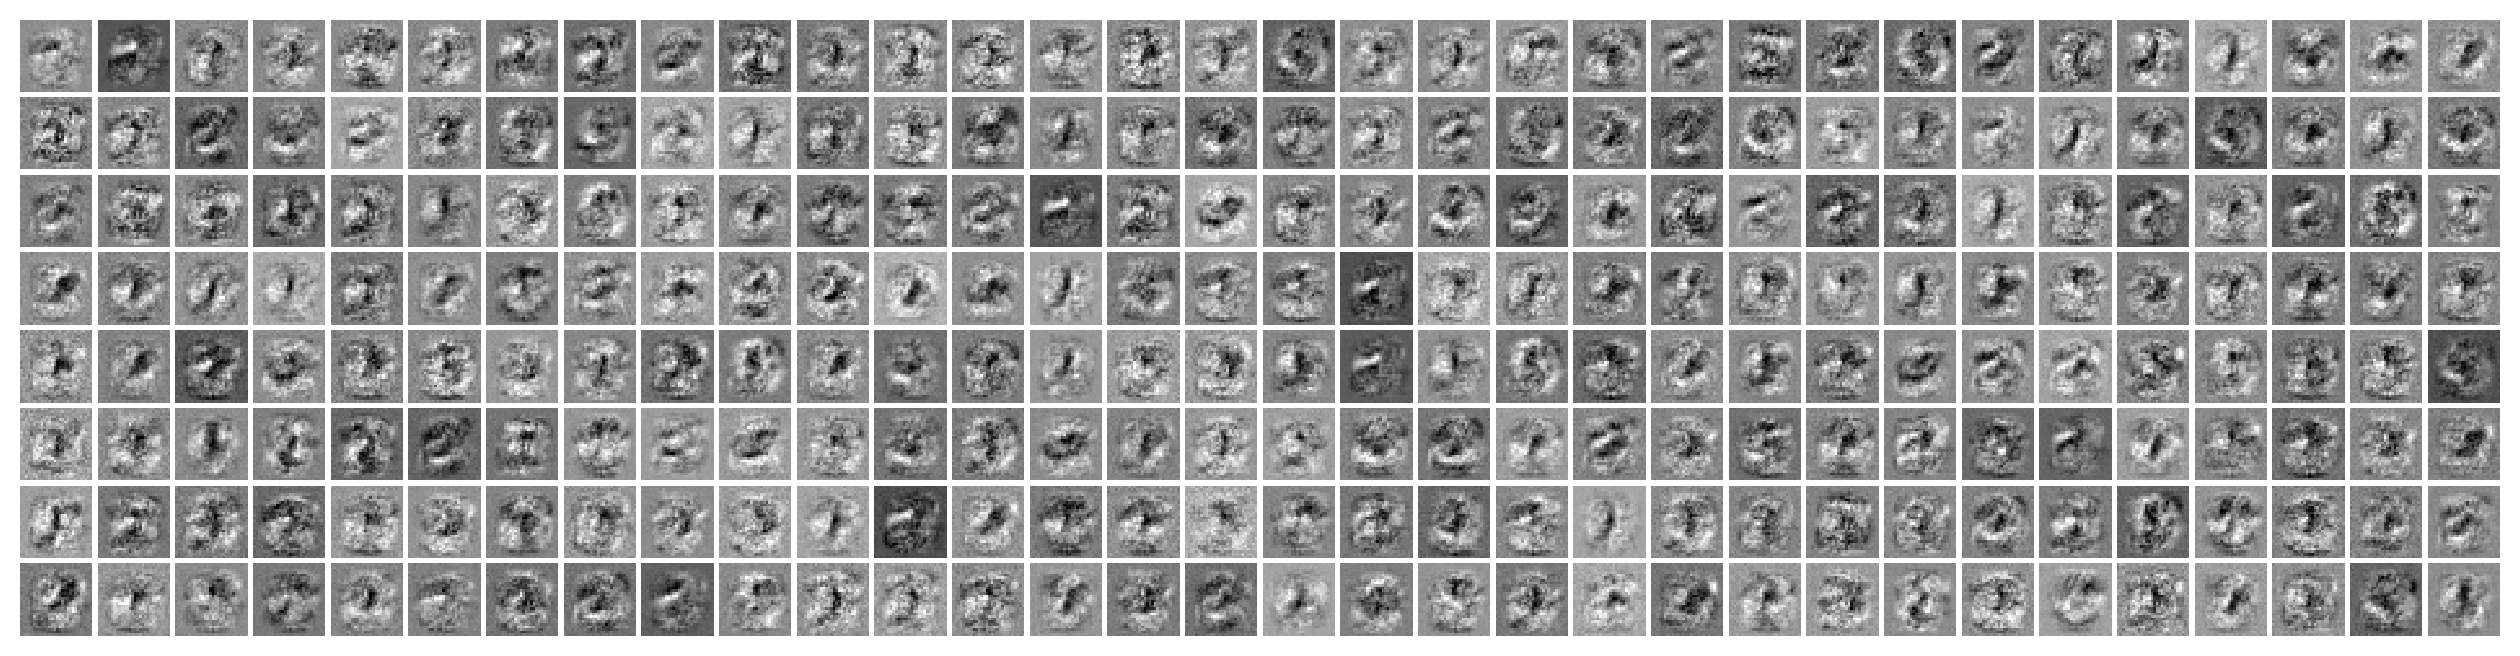

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: divide by zero encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: overflow encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: invalid value encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: divide by zero encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden) / observations_count
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: overflow encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden


Learning layer 0
Epoch 1:	########################################	elapsed: 0.10s, reconstruction error: 31.78
Epoch 2:	########################################	elapsed: 0.10s, reconstruction error: 24.92
Epoch 3:	########################################	elapsed: 0.10s, reconstruction error: 21.39
Epoch 4:	########################################	elapsed: 0.10s, reconstruction error: 19.02
Epoch 5:	########################################	elapsed: 0.11s, reconstruction error: 17.75
Epoch 6:	########################################	elapsed: 0.11s, reconstruction error: 15.35
Epoch 7:	########################################	elapsed: 0.12s, reconstruction error: 13.35
Epoch 8:	########################################	elapsed: 0.11s, reconstruction error: 12.39
Epoch 9:	########################################	elapsed: 0.11s, reconstruction error: 11.96
Epoch 10:	########################################	elapsed: 0.11s, reconstruction error: 11.46
Epoch 11:	###############################

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/1599231237.py:3: RuntimeWarning: divide by zero encountered in matmul
  visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/1599231237.py:3: RuntimeWarning: overflow encountered in matmul
  visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/1599231237.py:3: RuntimeWarning: invalid value encountered in matmul
  visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))


#####################################	elapsed: 0.08s, reconstruction error: 19.58
Epoch 2:	########################################	elapsed: 0.06s, reconstruction error: 14.93
Epoch 3:	########################################	elapsed: 0.06s, reconstruction error: 12.84
Epoch 4:	########################################	elapsed: 0.06s, reconstruction error: 11.39
Epoch 5:	########################################	elapsed: 0.06s, reconstruction error: 10.42
Epoch 6:	########################################	elapsed: 0.06s, reconstruction error: 8.64
Epoch 7:	########################################	elapsed: 0.06s, reconstruction error: 7.46
Epoch 8:	########################################	elapsed: 0.06s, reconstruction error: 6.70
Epoch 9:	########################################	elapsed: 0.06s, reconstruction error: 6.34
Epoch 10:	########################################	elapsed: 0.06s, reconstruction error: 5.95
Epoch 11:	########################################	elapsed: 0.06s, reconstru

Epoch 1:	########################################	elapsed: 0.06s, accuracy: 93.64
Epoch 2:	########################################	elapsed: 0.06s, accuracy: 94.99
Epoch 3:	########################################	elapsed: 0.06s, accuracy: 95.55
Epoch 4:	########################################	elapsed: 0.06s, accuracy: 95.80
Epoch 5:	########################################	elapsed: 0.05s, accuracy: 96.06
Epoch 6:	########################################	elapsed: 0.06s, accuracy: 96.24
Epoch 7:	########################################	elapsed: 0.06s, accuracy: 96.40
Epoch 8:	########################################	elapsed: 0.05s, accuracy: 96.52
Epoch 9:	########################################	elapsed: 0.07s, accuracy: 96.52
Epoch 10:	########################################	elapsed: 0.06s, accuracy: 96.56
Epoch 11:	########################################	elapsed: 0.06s, accuracy: 96.58
Epoch 12:	########################################	elapsed: 0.06s, accuracy: 96.59
Epoch 13:	###

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/736168039.py:31: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))


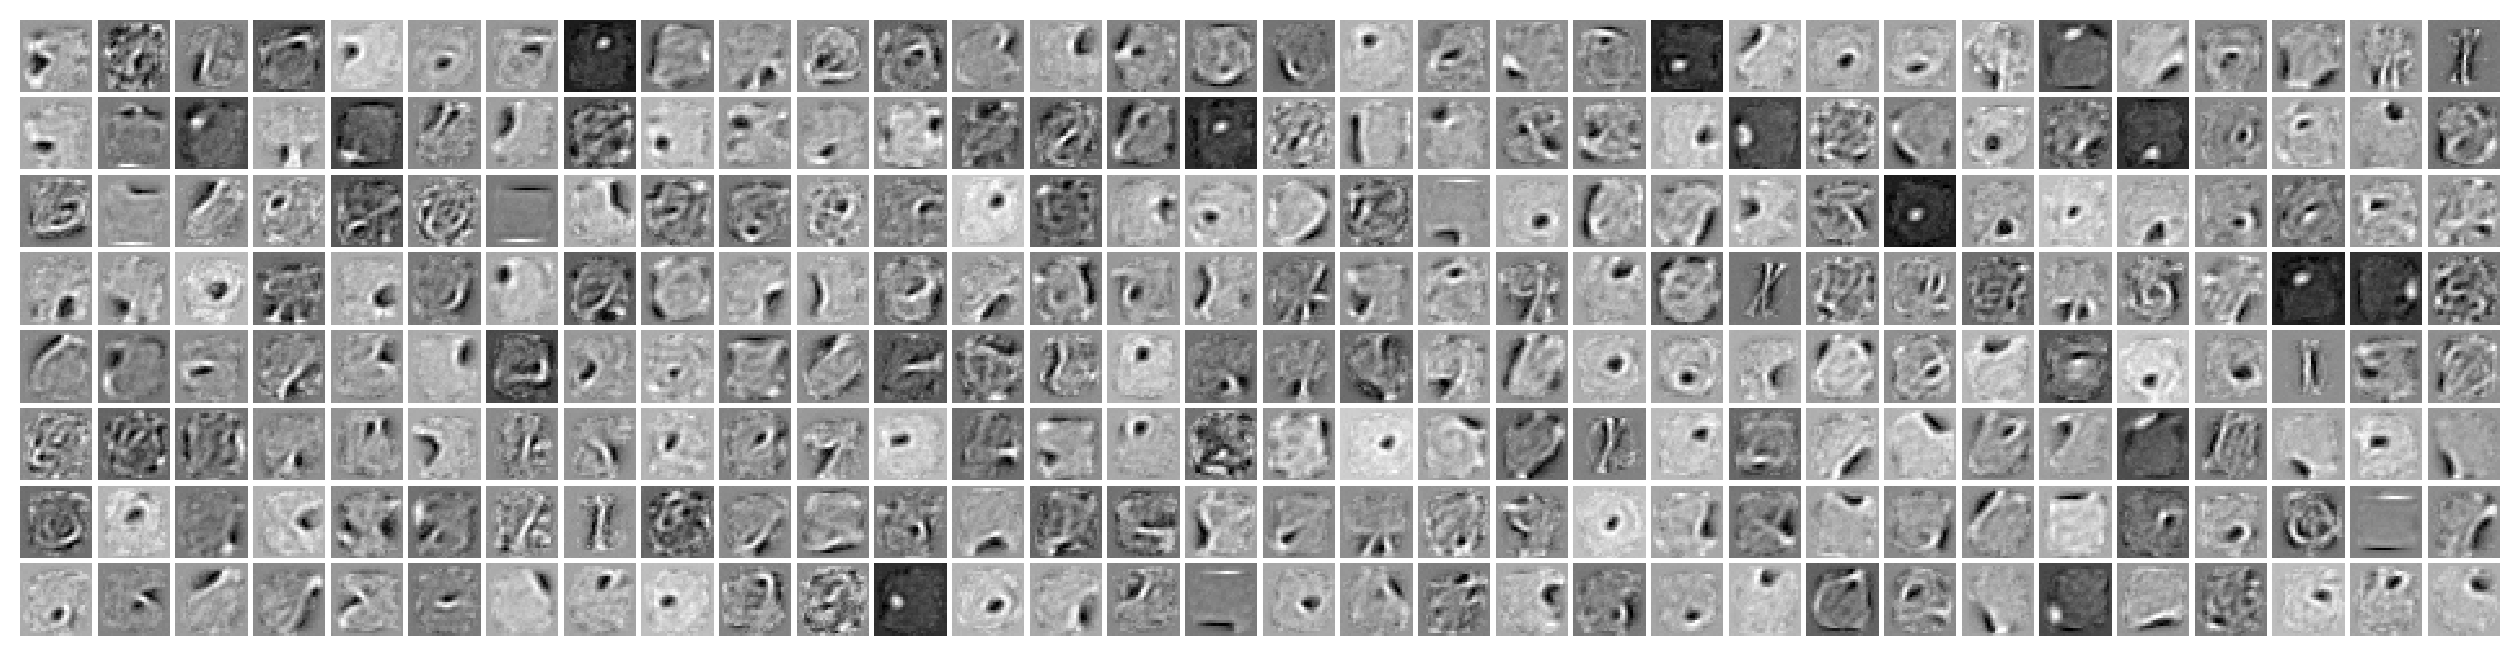

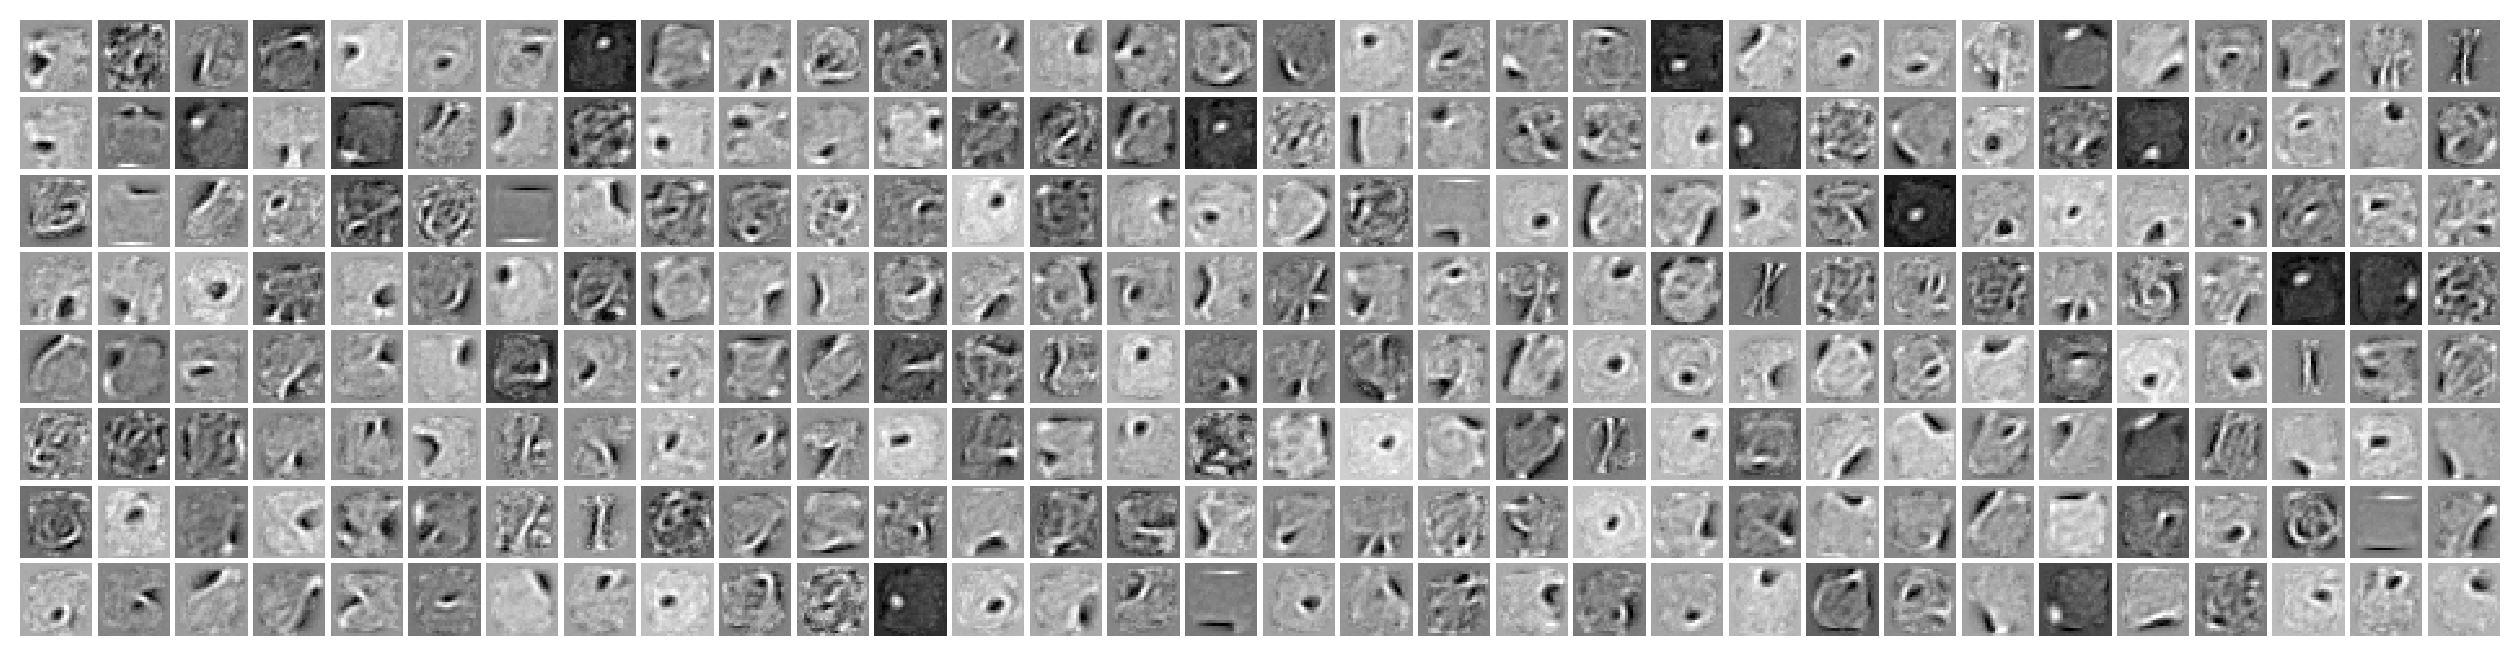

In [31]:
shallow_mlp = [
    Layer(
        VISIBLE_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        sigmoid_derivative,
        LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
    Layer(
        HIDDEN_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        sigmoid_derivative,
        LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
    Layer(
        HIDDEN_LAYER_SIZE,
        10,
        softmax,
        None,
        SOFTMAX_LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
]

shallow_dbn = [
    Rbm(
        mlp_layer.visible_size,
        mlp_layer.hidden_size,
        LEARNING_RATE,
        MOMENTUM,
        0.0,
        L2_PENALTY,
    )
    for mlp_layer in shallow_mlp[:-1]
]

compare_pretraining_results(
    shallow_mlp,
    shallow_dbn,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)

### Deep neural network


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2756254865.py:5: RuntimeWarning: divide by zero encountered in matmul
  z = visible @ layer.W
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2756254865.py:5: RuntimeWarning: overflow encountered in matmul
  z = visible @ layer.W
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2756254865.py:5: RuntimeWarning: invalid value encountered in matmul
  z = visible @ layer.W
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2385301240.py:10: RuntimeWarning: divide by zero encountered in matmul
  layer.deltas @ layer.W[:-1].T
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2385301240.py:10: RuntimeWarning: overflow encountered in matmul
  layer.deltas @ layer.W[:-1].T
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2385301240.py:10: RuntimeWarning: invalid value encountered in matmul
  layer.deltas @ layer.W[:-1].T
/var/folders/8j/_nnvcqj93gvgk18wy

Epoch 1:	########################################	elapsed: 0.08s, accuracy: 10.10
Epoch 2:	########################################	elapsed: 0.08s, accuracy: 10.10
Epoch 3:	########################################	elapsed: 0.08s, accuracy: 8.92
Epoch 4:	########################################	elapsed: 0.07s, accuracy: 8.92
Epoch 5:	########################################	elapsed: 0.08s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 0.08s, accuracy: 9.74
Epoch 7:	########################################	elapsed: 0.08s, accuracy: 9.74
Epoch 8:	########################################	elapsed: 0.08s, accuracy: 14.94
Epoch 9:	########################################	elapsed: 0.08s, accuracy: 14.05
Epoch 10:	########################################	elapsed: 0.08s, accuracy: 13.85
Epoch 11:	########################################	elapsed: 0.08s, accuracy: 14.54
Epoch 12:	########################################	elapsed: 0.08s, accuracy: 25.07
Epoch 13:	#######

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/174255805.py:36: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))


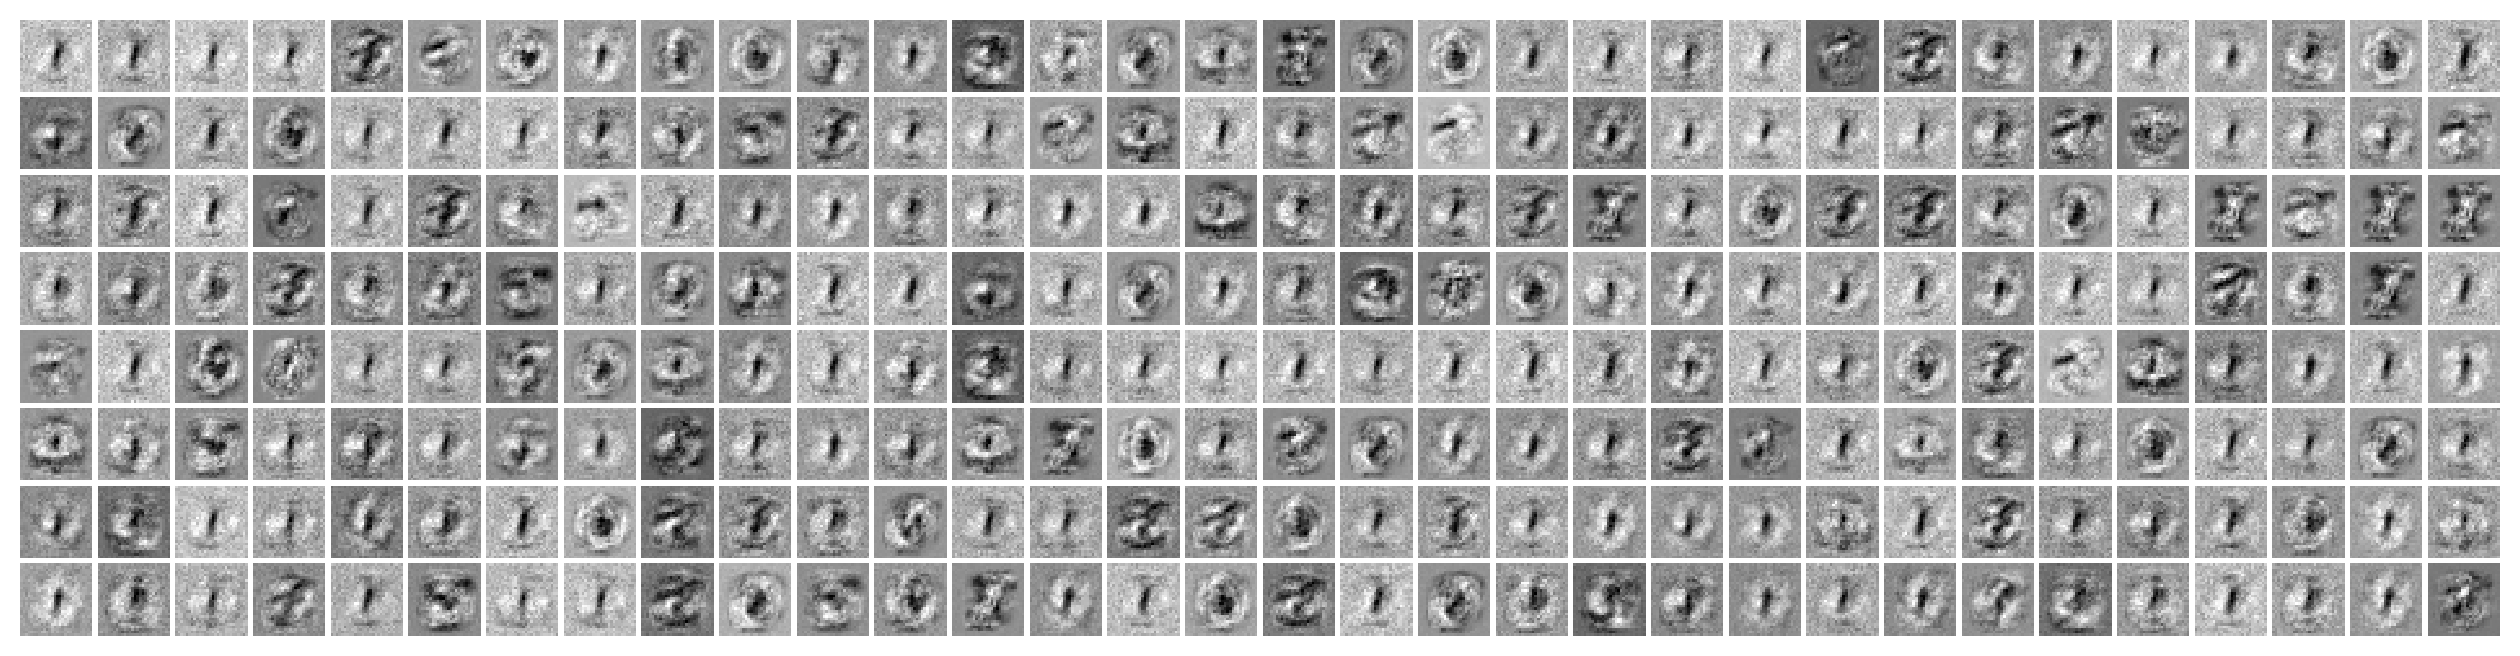


Learning layer 0
Epoch 1:	#####################################

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: divide by zero encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: overflow encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:21: RuntimeWarning: invalid value encountered in matmul
  positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: divide by zero encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden) / observations_count
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/4135528226.py:26: RuntimeWarning: overflow encountered in matmul
  pos_grad = (positive_visible.T @ positive_hidden

###	elapsed: 0.12s, reconstruction error: 31.43
Epoch 2:	############################

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2506539261.py:6: RuntimeWarning: divide by zero encountered in matmul
  hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2506539261.py:6: RuntimeWarning: overflow encountered in matmul
  hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2506539261.py:6: RuntimeWarning: invalid value encountered in matmul
  hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2506539261.py:9: RuntimeWarning: divide by zero encountered in matmul
  visible = sigmoid(hidden @ rbm.W[:-1, :].T)
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/2506539261.py:9: RuntimeWarning: overflow encountered in matmul
  visible = sigmoid(hidden @ rbm.W[:-1, :].T)
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_4

############	elapsed: 0.11s, reconstruction error: 24.62
Epoch 3:	########################################	elapsed: 0.11s, reconstruction error: 21.37
Epoch 4:	########################################	elapsed: 0.11s, reconstruction error: 19.19
Epoch 5:	########################################	elapsed: 0.11s, reconstruction error: 17.63
Epoch 6:	########################################	elapsed: 0.11s, reconstruction error: 15.12
Epoch 7:	########################################	elapsed: 0.11s, reconstruction error: 13.49
Epoch 8:	########################################	elapsed: 0.11s, reconstruction error: 12.44
Epoch 9:	########################################	elapsed: 0.11s, reconstruction error: 11.68
Epoch 10:	########################################	elapsed: 0.11s, reconstruction error: 11.28
Epoch 11:	########################################	elapsed: 0.11s, reconstruction error: 11.03
Epoch 12:	########################################	elapsed: 0.11s, reconstruction error: 10.72


/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/1599231237.py:3: RuntimeWarning: divide by zero encountered in matmul
  visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/1599231237.py:3: RuntimeWarning: overflow encountered in matmul
  visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/1599231237.py:3: RuntimeWarning: invalid value encountered in matmul
  visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))


########################################	elapsed: 0.06s, reconstruction error: 12.90
Epoch 4:	########################################	elapsed: 0.06s, reconstruction error: 11.50
Epoch 5:	########################################	elapsed: 0.06s, reconstruction error: 10.32
Epoch 6:	########################################	elapsed: 0.06s, reconstruction error: 8.47
Epoch 7:	########################################	elapsed: 0.06s, reconstruction error: 7.20
Epoch 8:	########################################	elapsed: 0.06s, reconstruction error: 6.68
Epoch 9:	########################################	elapsed: 0.06s, reconstruction error: 6.19
Epoch 10:	########################################	elapsed: 0.06s, reconstruction error: 5.89
Epoch 11:	########################################	elapsed: 0.06s, reconstruction error: 5.56
Epoch 12:	########################################	elapsed: 0.06s, reconstruction error: 5.42
Epoch 13:	########################################	elapsed: 0.06s, recons

Epoch 1:	########################################	elapsed: 0.09s, accuracy: 94.03
Epoch 2:	########################################	elapsed: 0.08s, accuracy: 94.98
Epoch 3:	########################################	elapsed: 0.08s, accuracy: 95.38
Epoch 4:	########################################	elapsed: 0.08s, accuracy: 95.76
Epoch 5:	########################################	elapsed: 0.08s, accuracy: 95.94
Epoch 6:	########################################	elapsed: 0.08s, accuracy: 96.13
Epoch 7:	########################################	elapsed: 0.08s, accuracy: 96.27
Epoch 8:	########################################	elapsed: 0.08s, accuracy: 96.36
Epoch 9:	########################################	elapsed: 0.08s, accuracy: 96.44
Epoch 10:	########################################	elapsed: 0.08s, accuracy: 96.56
Epoch 11:	########################################	elapsed: 0.08s, accuracy: 96.74
Epoch 12:	########################################	elapsed: 0.08s, accuracy: 96.77
Epoch 13:	###

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_45033/736168039.py:31: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))


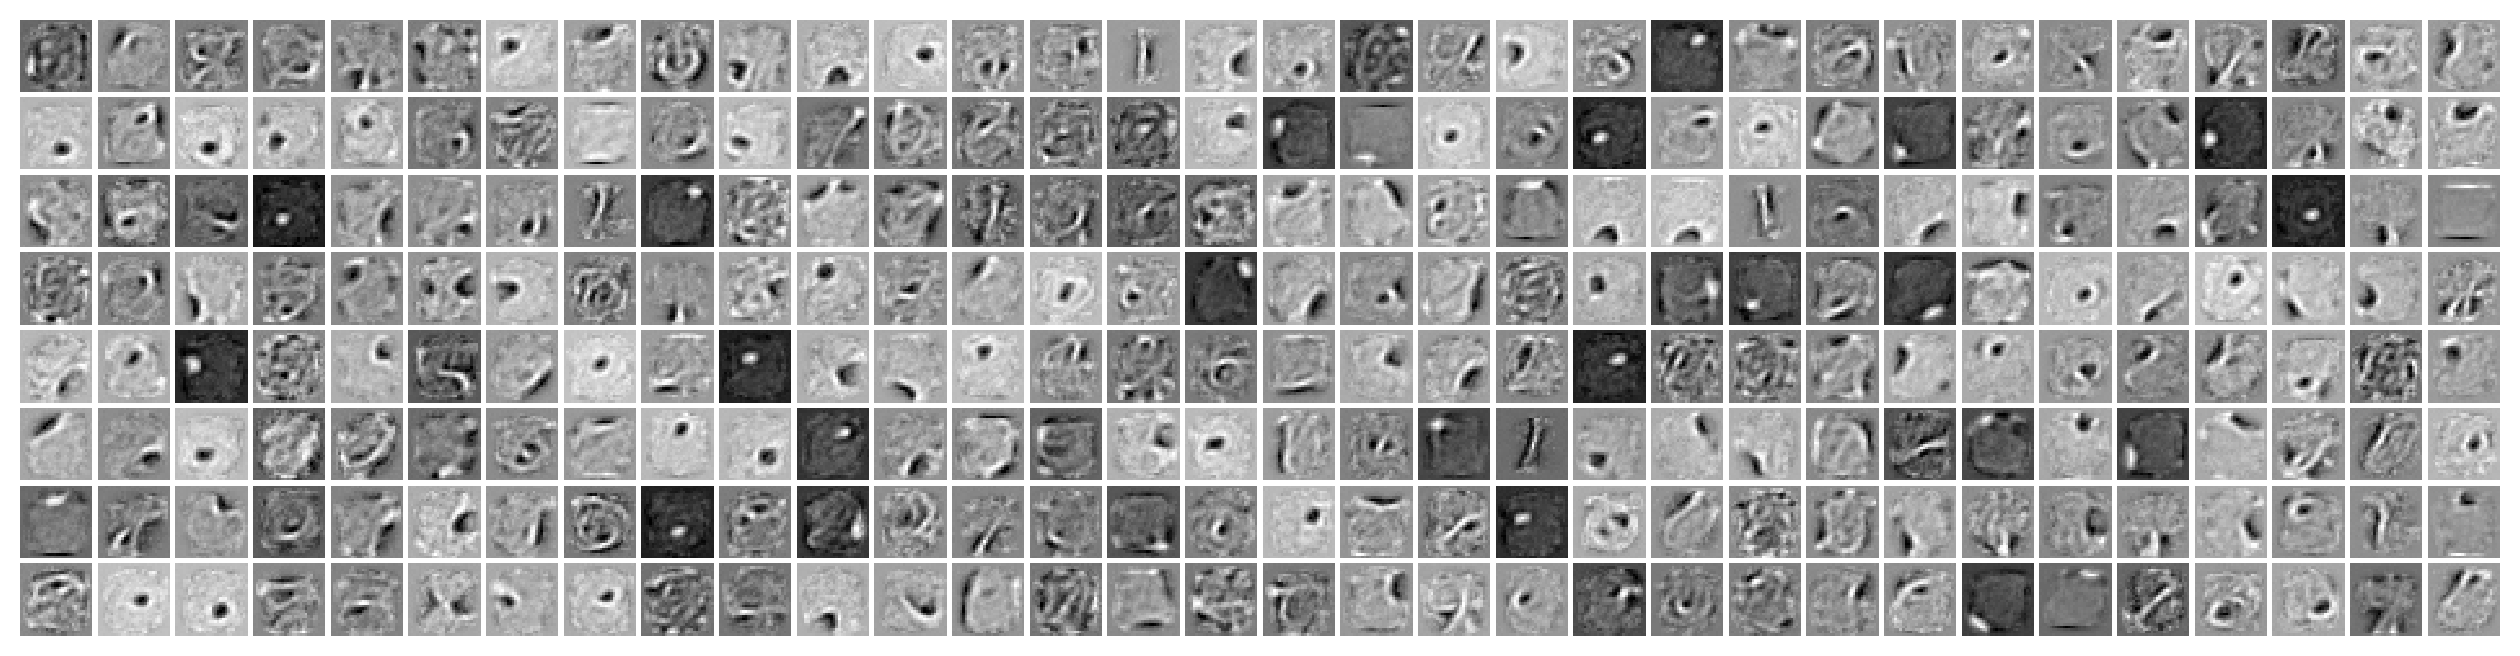

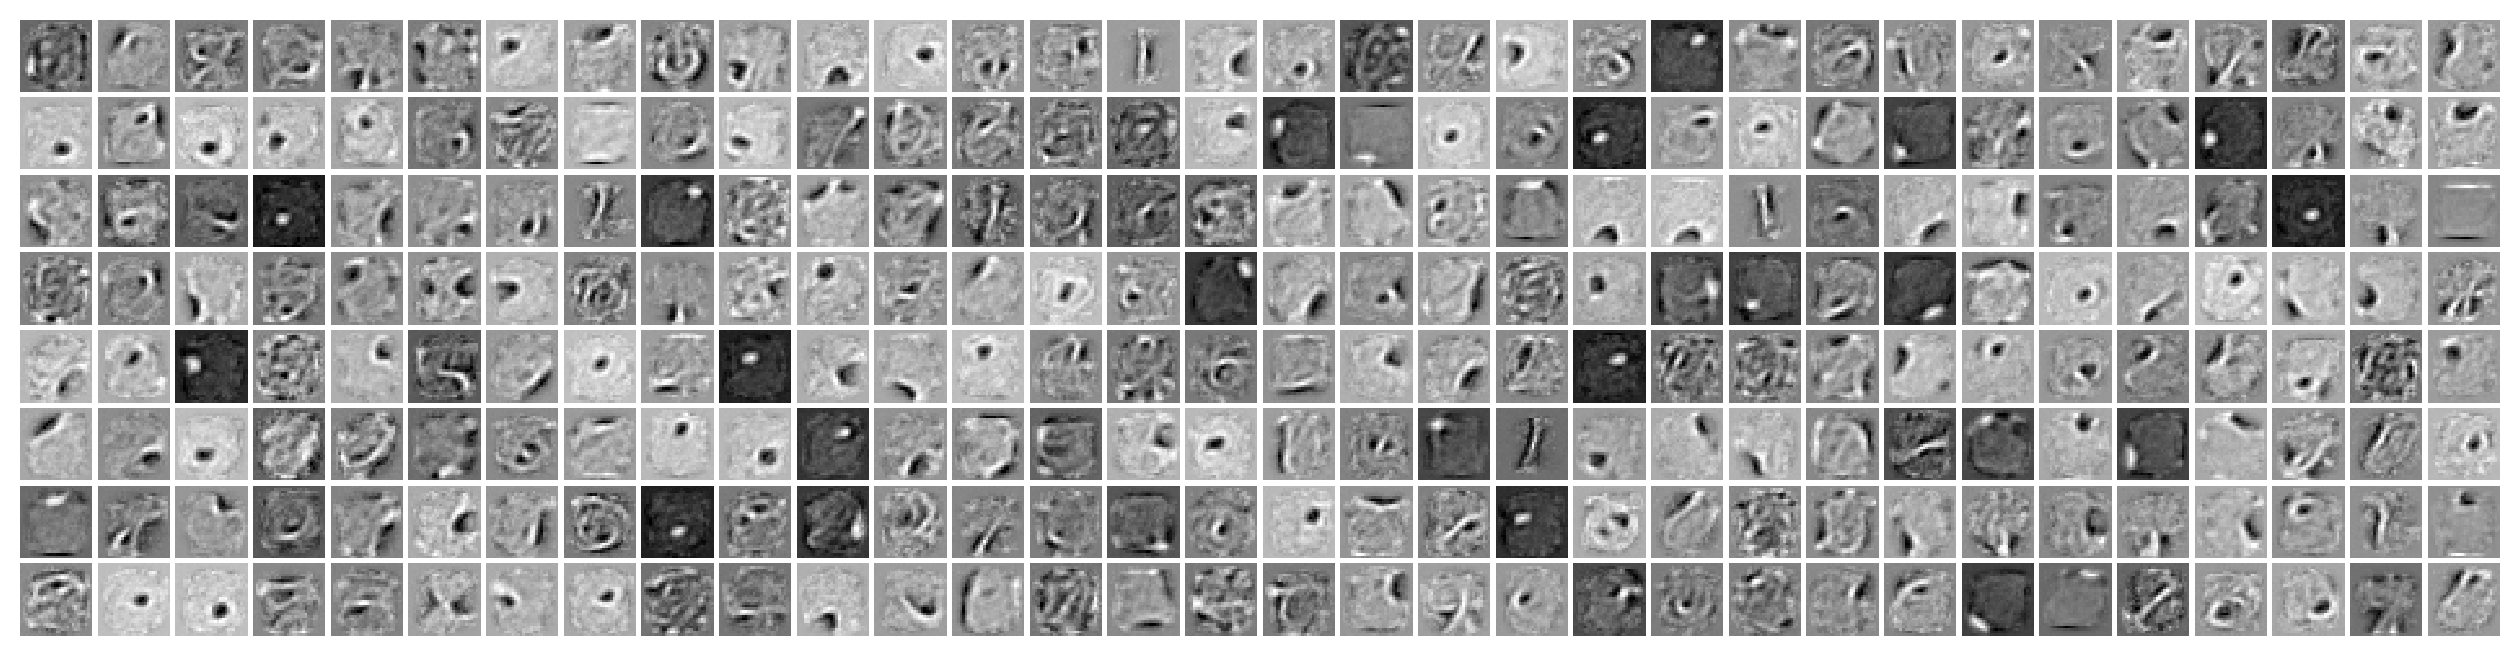

In [32]:
deep_mlp = [
    Layer(
        VISIBLE_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        sigmoid_derivative,
        LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
    Layer(
        HIDDEN_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        sigmoid_derivative,
        LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
    Layer(
        HIDDEN_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        sigmoid_derivative,
        LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
    Layer(
        HIDDEN_LAYER_SIZE,
        10,
        softmax,
        None,
        SOFTMAX_LEARNING_RATE,
        MOMENTUM,
        L2_PENALTY,
    ),
]

deep_dbn = [
    Rbm(
        mlp_layer.visible_size,
        mlp_layer.hidden_size,
        LEARNING_RATE,
        MOMENTUM,
        0.0,
        L2_PENALTY,
    )
    for mlp_layer in deep_mlp[:-1]
]

compare_pretraining_results(
    deep_mlp,
    deep_dbn,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)